# Pathway Activity in Human PBMC Single Cells

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes.

### Pathway activity tests

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* <cite>`aibar2017scenic`</cite>, pathway overdispersion analysis using *Pagoda2* <cite>`fan2016characterizing, lake2018integrative`</cite> and simple combined z-score <cite>`lee2008inferring`</cite>. 

*DoRothEA* <cite>`garcia2019benchmark`</cite> and *PROGENy* <cite>`schubert2018perturbation`</cite> are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. <cite>`holland2020robustness`</cite> found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. <cite>`zhang2020benchmarking`</cite> found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

#### Cluster Results
Following is a brief overview of the metrics we use to evaluate clustering results.

 - Silhouette Score: This score measures how similar a point is to its own cluster compared to other clusters. The silhouette_score function from sklearn.metrics is used. The Silhouette score ranges from -1 to 1, where a higher value indicates better-defined clusters. A score close to 0 suggests that clusters are overlapping or poorly defined. A negative value, as in this case, typically indicates that data points might have been assigned to the wrong clusters. Given that your score is slightly negative, it suggests potential issues with cluster separability or consistency.

 - Calinski-Harabasz Index: This index evaluates the ratio of the sum of between-cluster dispersion and of within-cluster dispersion. The calinski_harabasz_score function from sklearn.metrics is used. The Calinski-Harabasz index, also known as the Variance Ratio Criterion, is used to assess cluster separation. Higher values indicate better-defined clusters.
 
 - Dunn Index: This index is calculated by finding the minimum inter-cluster distance and dividing it by the maximum intra-cluster distance. The custom function dunn_index is used to compute this.
 The Dunn index evaluates cluster compactness and separation. Higher values are better, indicating well-separated and compact clusters.

We first download the 68K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes.

In [2]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler
from tqdm.notebook import tqdm
import session_info
import os
import warnings
import scanpy.external as sce
from metrics import *
import scprep
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
import magic
from activity import *
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from scipy import stats


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.logging.print_versions()
#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
activity            NA
asttokens           NA
cffi                1.17.1
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.8
decorator           5.1.1
decoupler           1.5.0
deprecated          1.2.15
exceptiongroup      1.2.1
executing           2.1.0
future              1.0.0
graphtools          1.5.3
h5py                3.11.0
ipykernel           6.29.5
ipywidgets          8.1.5
jedi                0.19.2
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
magic               3.0.0
matplotlib          3.9.0
matplotlib_inline   0.1.7
metrics             NA
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numpy               1.26.4
packaging           24.2
pandas              2.2.2
parso               0.8.4
patsy            

The original dataset is from a single donor, from 10xgenomix. Fresh 68k PBMCs (Donor A).

- ~68,000 cells detected
- Sequenced on Illumina NextSeq 500 High Output with ~20,000 reads per cell
- 98bp read1 (transcript), 8bp I5 sample barcode, 14bp I7 GemCode barcode and 5bp read2 (UMI)
- Analysis run with --cells=24000

In [3]:
adata = sc.datasets.pbmc68k_reduced()
adata.obs['labels'] = adata.obs.bulk_labels.map({'CD14+ Monocyte':0, 'Dendritic':1, 'CD56+ NK':2, 'CD4+/CD25 T Reg':3, 'CD19+ B':4, 'CD8+ Cytotoxic T':5, 'CD4+/CD45RO+ Memory':6, 'CD8+/CD45RA+ Naive Cytotoxic':7, 'CD4+/CD45RA+/CD25- Naive T':8, 'CD34+':9})
true_labels = adata.obs.labels
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'labels'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

It seems that preprocessing steps such as normalization and scaling were already performed on the dataset.

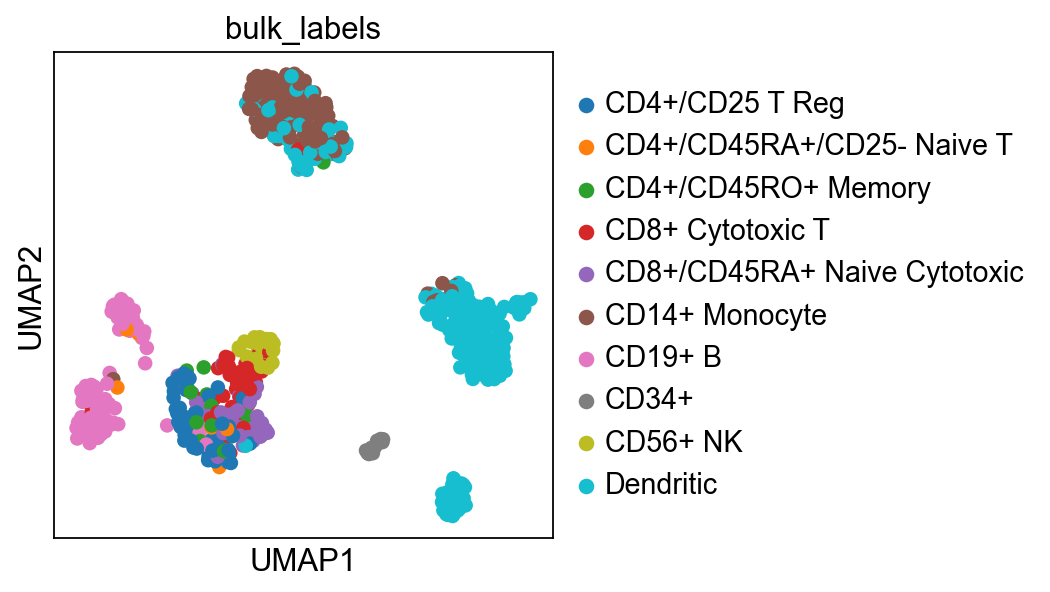

In [4]:
sc.pl.umap(adata, color=["bulk_labels"])

### Run Magic

In [4]:
print(adata.raw.to_adata().X.toarray()[:5,:5])
sce.pp.magic(adata, name_list='all_genes')
print(adata.raw.to_adata().X[:5,:5])

[[0.    0.    0.    1.591 1.591]
 [1.55  0.    1.55  0.    0.   ]
 [0.    0.    1.374 0.    0.   ]
 [0.    0.    1.711 1.711 0.   ]
 [0.    0.    0.    1.275 0.   ]]
[[-0.326 -0.191 -0.728 -0.301  3.386]
 [ 1.171 -0.191  0.795 -1.2   -0.174]
 [-0.326 -0.191  0.483 -1.2   -0.174]
 [-0.326 -0.191  1.134 -0.157 -0.174]
 [-0.326 -0.191 -0.728 -0.607 -0.174]]


#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [5]:
#Downloading reactome pathways.
if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


In [6]:
def run_method(method_name, method):
    Silhouette_scores = []
    Calinski_scores = []
    Special_scores = []
    Completeness_scores = []
    Homogeneity_scores = []
    Adjusted_scores = []
    for _ in tqdm(range(30)):
        pathway_activity_df = method()
        #Perform KMeans clustering and plot UMAP.
        kmeans = cluster_with_kmeans(method_name, pathway_activity_df, adata, n_clusters=10)

        #Metric results.
        Silhouette, Calinski, Special, Completeness, Homogeneity, Adjusted = print_stats(pathway_activity_df, true_labels, kmeans.labels_)
        Silhouette_scores.append(Silhouette)
        Calinski_scores.append(Calinski)
        Special_scores.append(Special)
        Completeness_scores.append(Completeness)
        Homogeneity_scores.append(Homogeneity)
        Adjusted_scores.append(Adjusted)

    print(f'Results for {method_name}:')
    for metric in [Silhouette_scores, Calinski_scores, Special_scores, Completeness_scores, Homogeneity_scores, Adjusted_scores]:
        print(f"mean: {np.mean(metric)}, cl: {stats.t.interval(0.95, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))}")

## GSEA

#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [ ]:
def run_gsea():
    #Prepare the result matrix for GSEA scores.
    num_cells = adata.shape[0]
    num_gene_sets = len(reactome['geneset'].unique())
    gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

    #Loop through each cell to run GSEA.
    for cell_index in tqdm(range(num_cells)):
        #Get normalized expression values for the specific cell.
        cell_expr = adata.X[cell_index]
        
        #Create a DataFrame to hold DE scores.
        de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
        
        #Run GSEA using decoupler.
        _, norm, _ = decoupler.run_gsea(
            de_scores.T,
            reactome,
            source="geneset",
            target="genesymbol"
        )
        
        #Store the normalized enrichment scores (NES) in the result matrix.
        gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values
    return gsea_results_matrix

#Save the result matrix for later use.
#np.save('./data/gsea_results_matrix.npy', gsea_results_matrix)
run_method('gsea', run_gsea)

### Cluster With KMeans

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


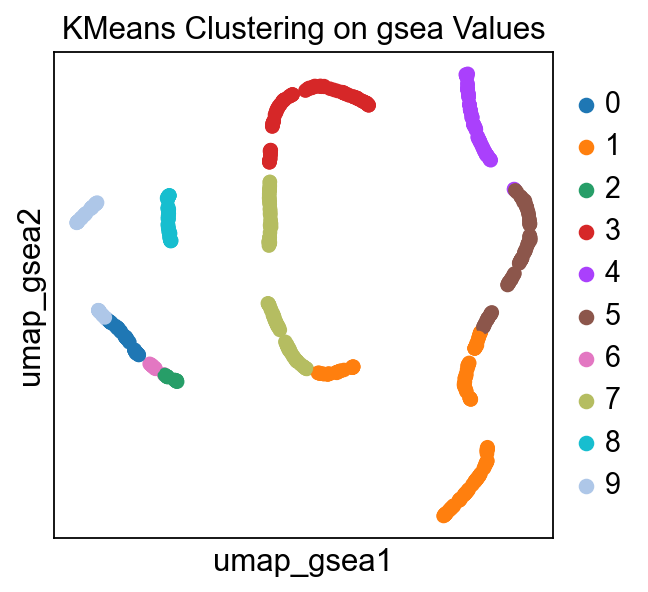

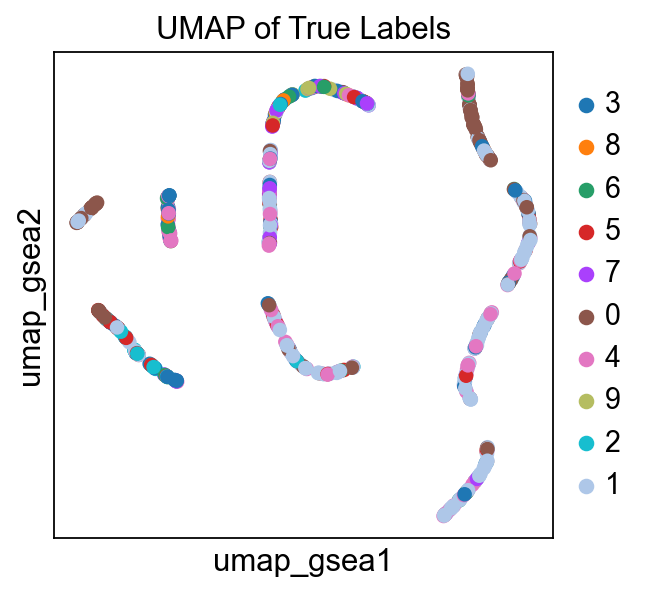

Silhouette Score: 0.5818618817999396
Calinski-Harabasz Index: 17819.743450336544
Special accuracy: 0.3314285714285714
completeness score: 0.22306129171029385
homogeneity_score: 0.2461920972304762
adjusted_mutual_info_score: 0.2096547513727912


In [14]:
#Load the GSEA results matrix.
results_matrix = np.load('./data/gsea_results_matrix.npy')

#Perform KMeans clustering and plot UMAP.
kmeans = cluster_with_kmeans('gsea', results_matrix, adata, n_clusters=10)

#Print metric results.
print_stats(results_matrix, true_labels, kmeans.labels_)

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [ ]:
progeny = decoupler.get_progeny(organism='human', top=2000)

def run_progeny():
    decoupler.run_mlm(mat=adata, net=progeny, source='source', target='target', weight='weight',
                    verbose=True, use_raw=False)
    acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

    #Convert the pathway activity matrix to a DataFrame.
    return pd.DataFrame(acts.obsm['mlm_estimate'], index=adata.obs_names, columns=acts.var_names)

run_method('progeny', run_progeny)

### Cluster With KMeans

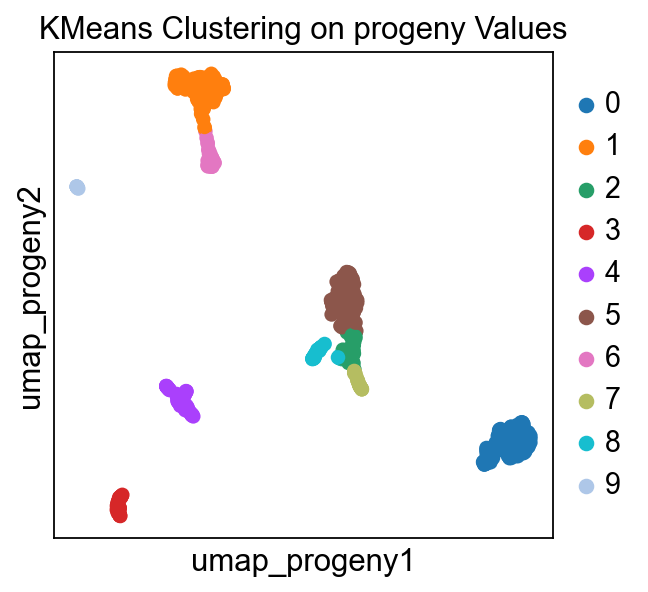

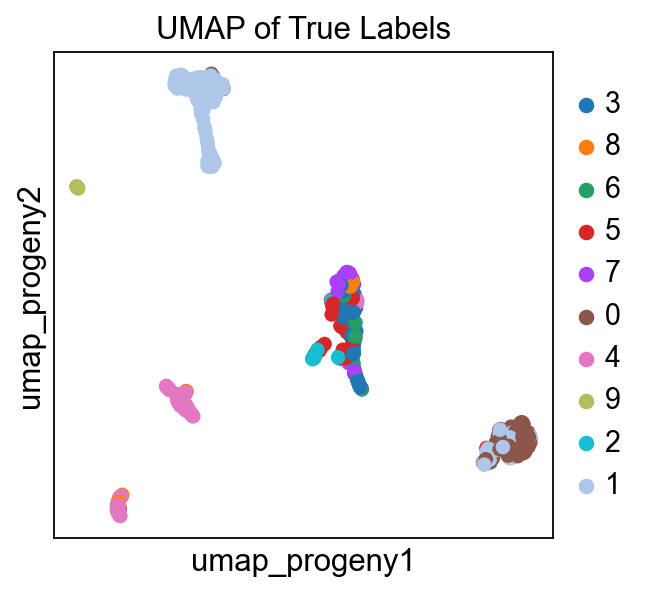

Silhouette Score: 0.5760536789894104
Calinski-Harabasz Index: 1936.2525824712718
Special accuracy: 0.6185714285714285
completeness score: 0.6103298160386383
homogeneity_score: 0.6381419243435271
adjusted_mutual_info_score: 0.6115564849083172


In [ ]:
acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(acts.obsm['mlm_estimate'], index=adata.obs_names, columns=acts.var_names)

#Perform KMeans clustering and plot UMAP.
kmeans = cluster_with_kmeans('progeny', pathway_activity_df, adata, n_clusters=10)

#Print metric results.
print_stats(pathway_activity_df, true_labels, kmeans.labels_)

## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [ ]:
def run_aucell():
    decoupler.run_aucell(
        adata,
        reactome,
        source="geneset",
        target="genesymbol",
        use_raw=False,
        verbose=True
    )
    return adata.obsm["aucell_estimate"]

run_method('aucell', run_aucell)

Running aucell on mat with 700 samples and 765 targets for 266 sources.


100%|██████████| 700/700 [00:01<00:00, 608.08it/s]


### Cluster With KMeans

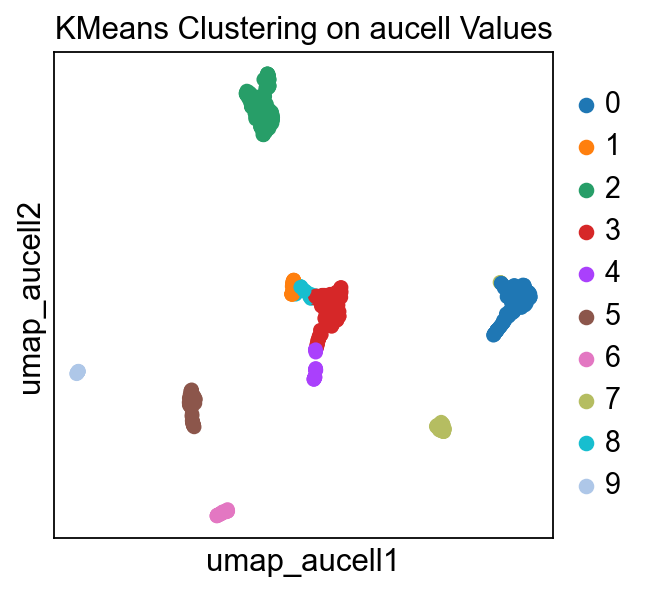

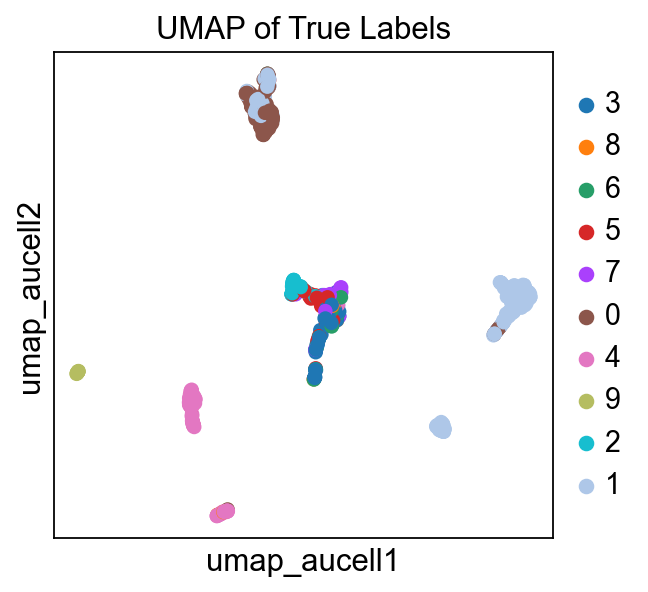

Silhouette Score: 0.6168209314346313
Calinski-Harabasz Index: 995.4903790781322
Special accuracy: 0.62
completeness score: 0.6272223160995016
homogeneity_score: 0.6461136193524781
adjusted_mutual_info_score: 0.6245213624187206


In [93]:
pathway_activity_df = adata.obsm["aucell_estimate"]

#Perform KMeans clustering and plot UMAP.
kmeans = cluster_with_kmeans('aucell', pathway_activity_df, adata, n_clusters=10)

#Print metric results.
print_stats(pathway_activity_df, true_labels, kmeans.labels_)

## PathSingle

In [ ]:
def run_pathsingle():
    activity_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    #magic_op = magic.MAGIC()
    #activity_df = magic_op.fit_transform(activity_df)
    activity = sc.AnnData(activity_df)

    calc_activity(activity)
    output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

    #selector = VarianceThreshold(threshold=0.01)
    #output_activity = selector.fit_transform(output_activity)

    #Scale the data.
    scaler = MinMaxScaler()
    output_activity = scaler.fit_transform(output_activity)
    PCA = PCA(n_components=50, svd_solver='arpack')
    output_activity = PCA.fit_transform(output_activity)
    return output_activity

run_method('pathsingle', run_pathsingle)

AnnData object with n_obs × n_vars = 700 × 765


100%|██████████| 140/140 [01:40<00:00,  1.39it/s]


### Cluster With KMeans

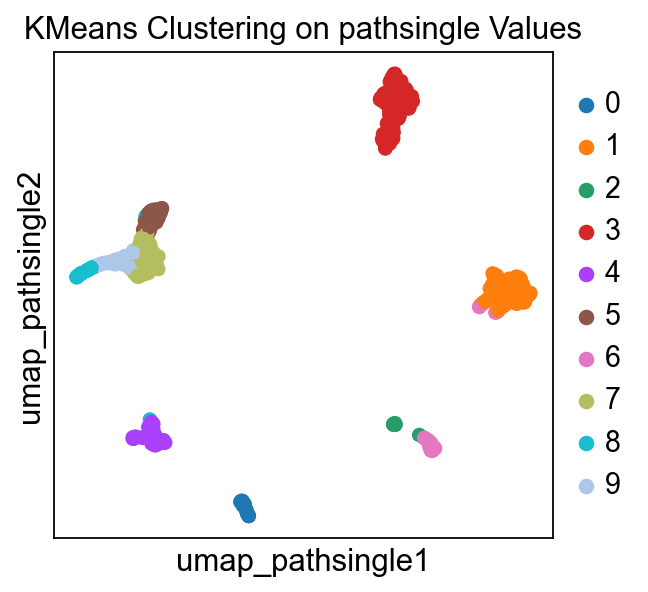

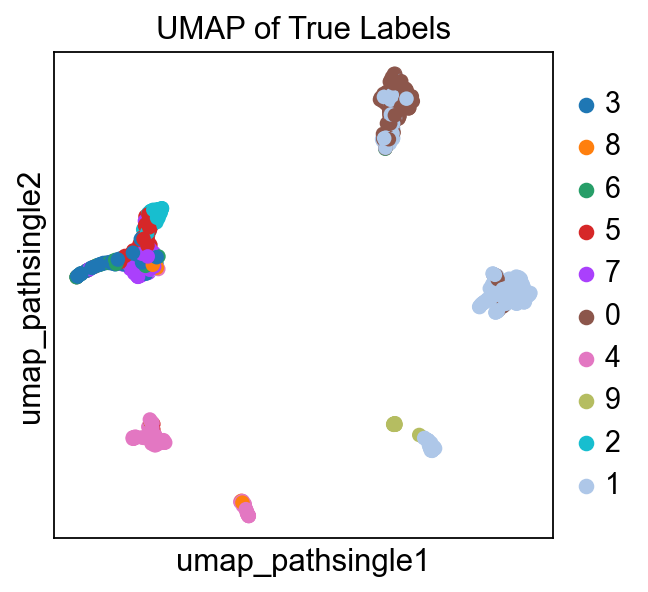

Silhouette Score: 0.5577373354652382
Calinski-Harabasz Index: 1055.0147987294065
Special accuracy: 0.6214285714285714
completeness score: 0.6103618744991666
homogeneity_score: 0.6504527943574239
adjusted_mutual_info_score: 0.6176909258981184


In [89]:
#Perform KMeans clustering and plot UMAP.
kmeans = cluster_with_kmeans('pathsingle', output_activity, adata, n_clusters=10)

#Print metric results.
print_stats(output_activity, true_labels, kmeans.labels_)

In [134]:
adata.write("./data/adata_pbmc.h5ad")

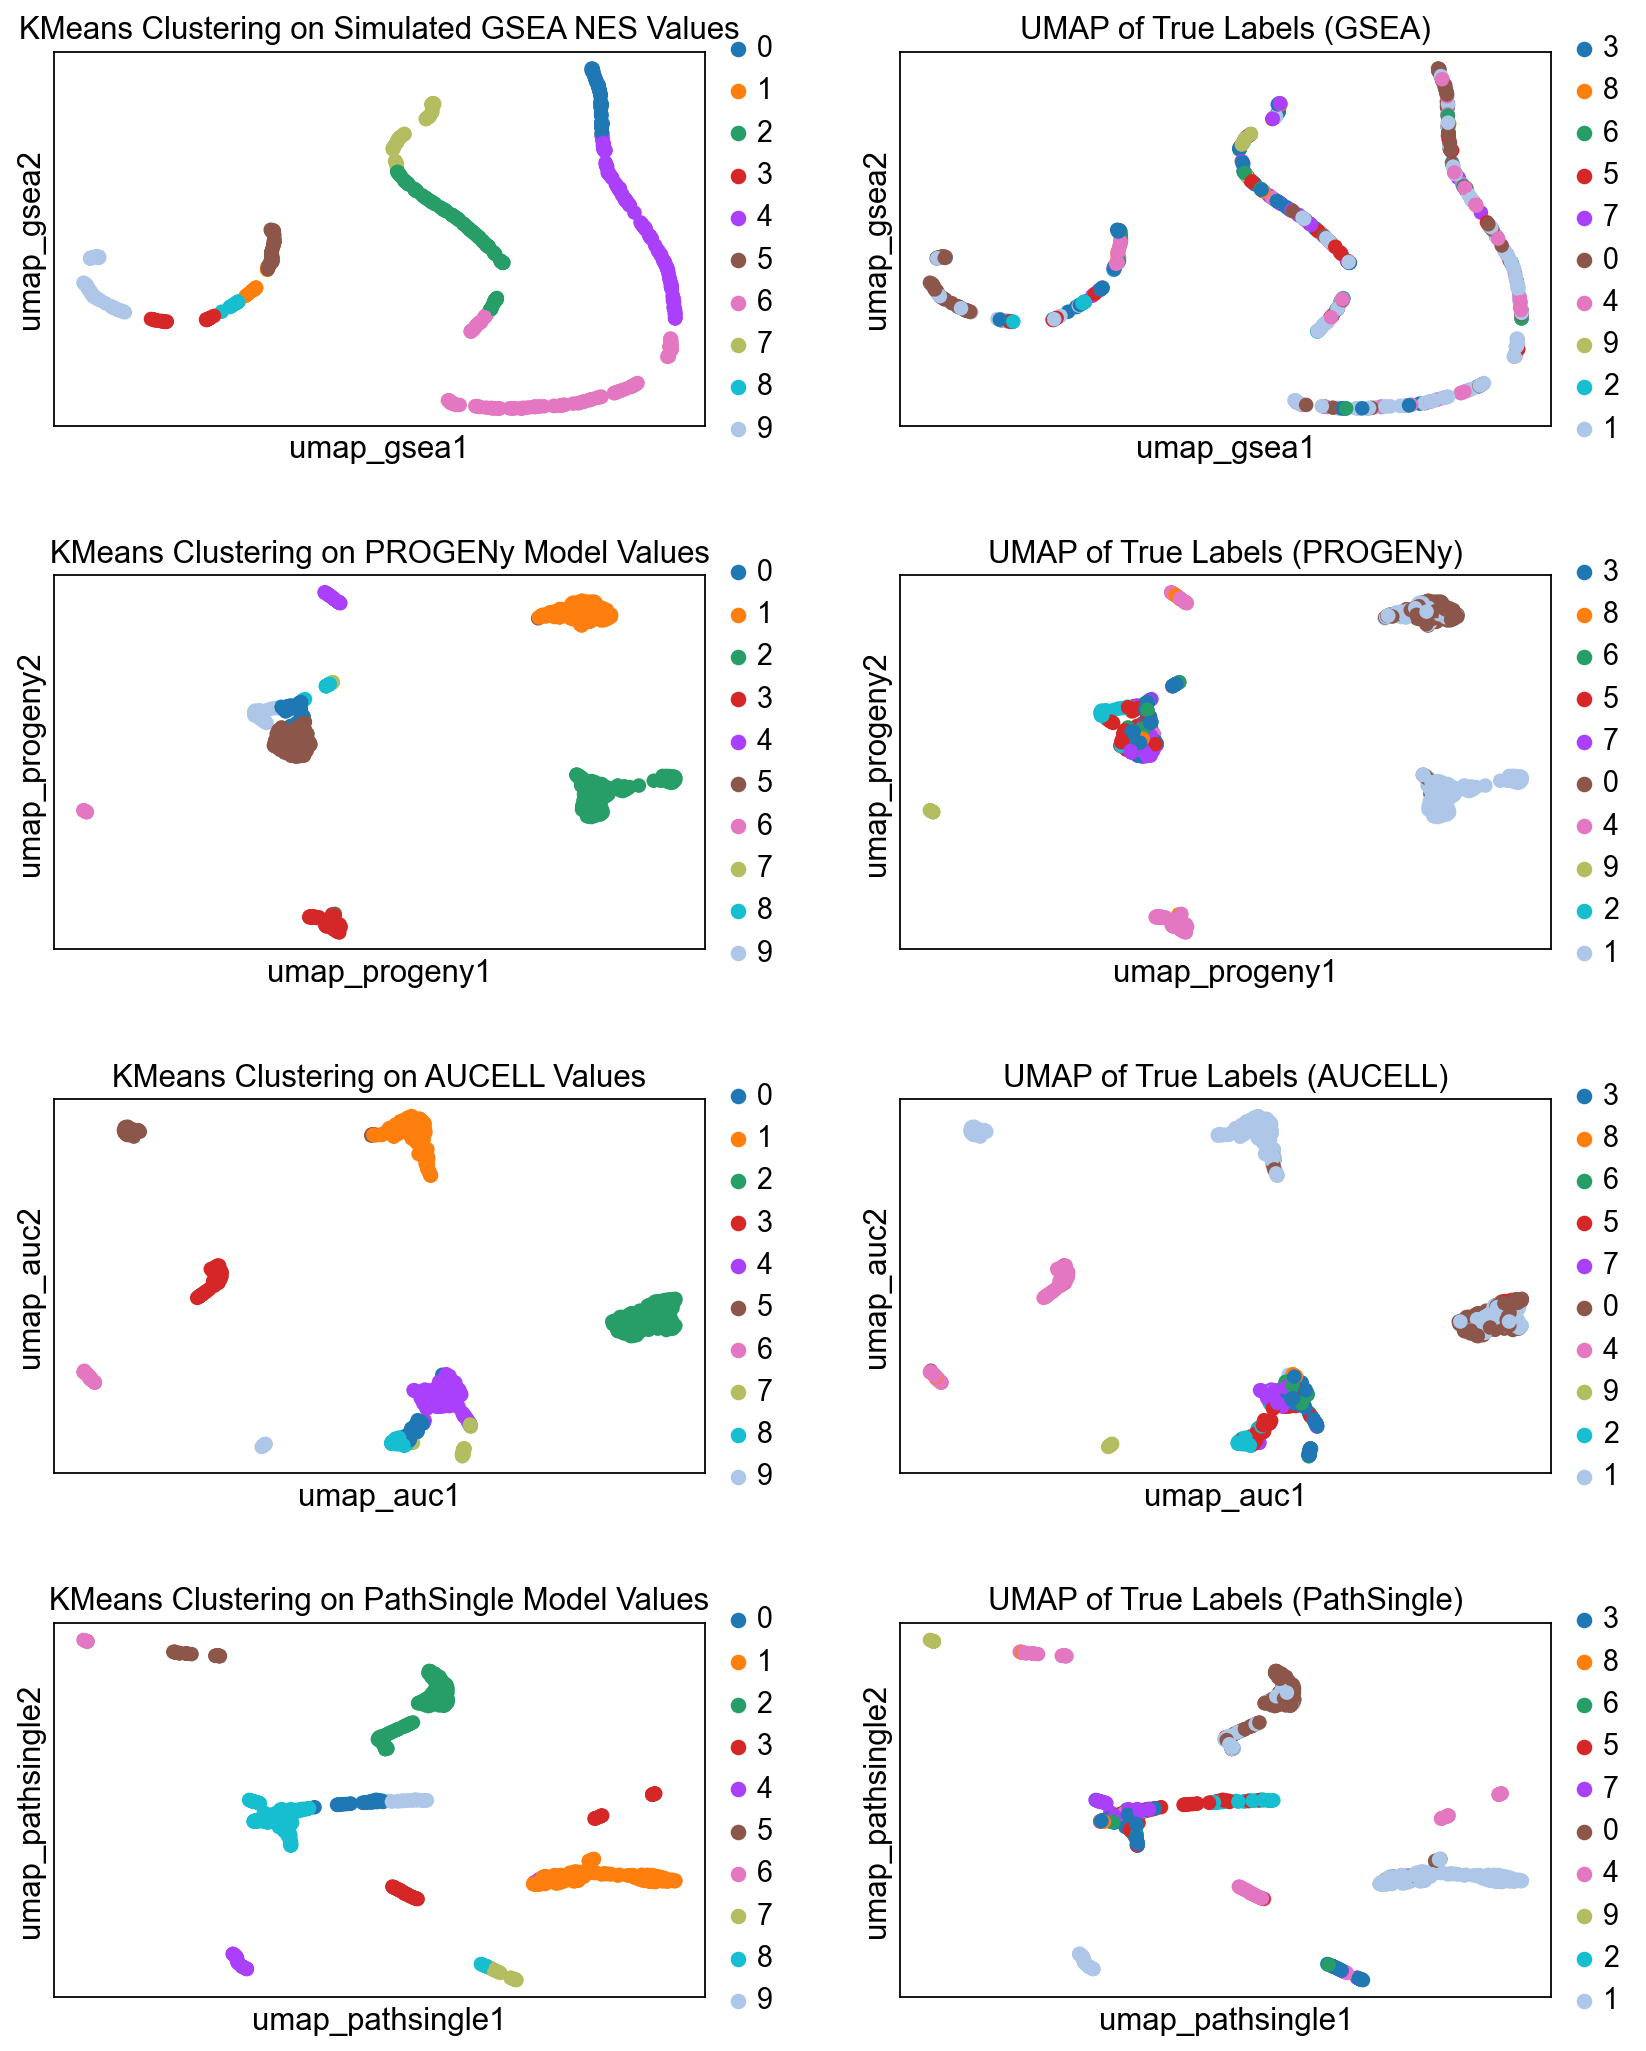

In [135]:
#adata = sc.read_h5ad("./data/adata_pbmc.h5ad")
# Define a figure with a 4x2 grid (4 rows, 2 columns).
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Adjust the spacing between plots.
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Define the plotting function for each subplot using sc.pl.embedding.
def plot_umap(ax, adata, umap_key, color, title):
    sc.pl.embedding(adata, basis=umap_key, color=color, title=title, ax=ax, show=False)
    ax.set_frame_on(True)  # Add a frame to each subplot.

# Plot each UMAP with its KMeans clustering and true labels side by side.

# Plot UMAP for GSEA.
plot_umap(axs[0, 0], adata, 'umap_gsea', color='kmeans_gsea', title='KMeans Clustering on Simulated GSEA NES Values')
plot_umap(axs[0, 1], adata, 'umap_gsea', color="labels", title="UMAP of True Labels (GSEA)")

# Plot UMAP for PROGENy.
plot_umap(axs[1, 0], adata, 'umap_progeny', color="kmeans_progeny", title="KMeans Clustering on PROGENy Model Values")
plot_umap(axs[1, 1], adata, 'umap_progeny', color="labels", title="UMAP of True Labels (PROGENy)")

# Plot UMAP for AUCELL.
plot_umap(axs[2, 0], adata, 'umap_auc', color="kmeans_auc", title="KMeans Clustering on AUCELL Values")
plot_umap(axs[2, 1], adata, 'umap_auc', color="labels", title="UMAP of True Labels (AUCELL)")

# Plot UMAP for PathSingle.
plot_umap(axs[3, 0], adata, 'umap_pathsingle', color="kmeans_pathsingle", title="KMeans Clustering on PathSingle Model Values")
plot_umap(axs[3, 1], adata, 'umap_pathsingle', color="labels", title="UMAP of True Labels (PathSingle)")

# Save the figure to a file.
plt.savefig("umap_clustering_layout.png", dpi=300, bbox_inches='tight')

# Show the figure.
plt.show()

## Session info

In [12]:
session_info.show()

### References

https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.html

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc68k_reduced.html#norm

https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

https://www.10xgenomics.com/datasets/fresh-68-k-pbm-cs-donor-a-1-standard-1-1-0